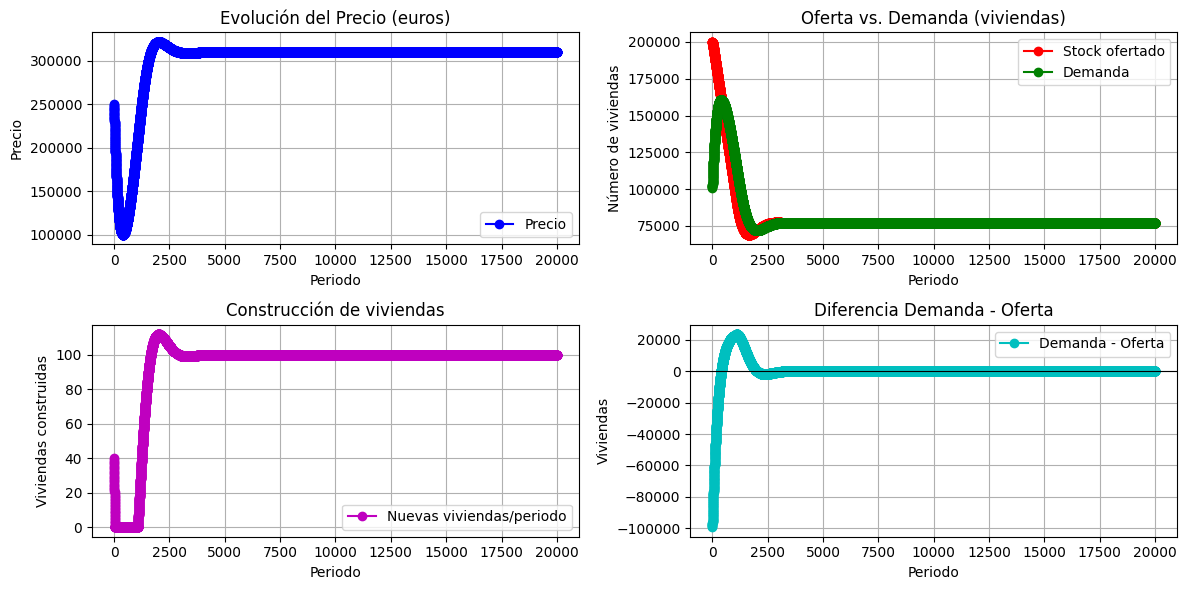

In [28]:

#----------------------------------------------------------------------------
# MODELO DINÁMICO DE OFERTA Y DEMANDA (SIN ESCALADO)
# ---------------------------------------------------
# - Qd(t) y Qs(t) representan número de viviendas.
# - P(t), C(t) representan euros (precio de la vivienda o coste de construcción).
# - r(t) representa tasa de interés en %, p.e. r(t)=3 -> 3% anual.
# - X(t) es una variable exógena (por ejemplo, población, renta, etc.) en su unidad correspondiente.
# - R_const es el número absoluto de viviendas que se retiran/demuelen cada periodo.
# Tú escoges el significado temporal de cada periodo (mes, trimestre, año...).
# ----------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

def simulate_housing_market(
    T, 
    alpha_d, beta_d, gamma_d, delta_d,   # Parámetros de la demanda
    alpha_s, beta_s,                     # Parámetros de la construcción/oferta nueva
    k,                                   # Velocidad de ajuste de precios
    P0, Qs0,                             # Precio y stock iniciales
    r0, C0, X0,                          # Tasa interes, coste construcción, variable exógena inicial
    R_const=0                            # Número ABSOLUTO de viviendas que se retiran cada periodo
):
    """
    Simula un modelo dinámico (discreto) de mercado de vivienda, interpretando
    todos los parámetros en su magnitud real (sin factor de miles ni escalado).

    Ecuaciones (forma lineal muy básica):
      1) Qd(t) = alpha_d - beta_d*P(t) - gamma_d*r(t) + delta_d*X(t)
      2) I(t)  = max(0, alpha_s + beta_s*(P(t) - C(t)))
      3) Qs(t+1) = Qs(t) + I(t) - R_const
      4) P(t+1)  = P(t) + k * [ Qd(t) - Qs(t) ]

    Parámetros:
    -----------
    - T       : número de periodos a simular
    - alpha_d : parámetro base de la demanda (viviendas)
    - beta_d  : sensibilidad de la demanda al precio (P en euros)
    - gamma_d : sensibilidad de la demanda a la tasa de interés (r en %)
    - delta_d : sensibilidad de la demanda a X(t) (variable exógena)
    - alpha_s : término base de nueva oferta (unidades de vivienda)
    - beta_s  : sensibilidad de la construcción a la rentabilidad [P(t) - C(t)]
    - k       : velocidad de ajuste del precio
    - P0      : precio inicial de la vivienda (en euros)
    - Qs0     : stock inicial de viviendas
    - r0      : tasa de interés inicial (en %)
    - C0      : coste de construcción (en euros)
    - X0      : valor inicial de la variable exógena (población, renta, etc.)
    - R_const : nº de viviendas que se destruyen/retiran cada periodo (obsolescencia, demolición)

    Retorna:
    --------
    Un diccionario con las trayectorias de:
      - 'P'  : array con la evolución del precio en euros
      - 'Qs' : array con la evolución del stock (oferta) de viviendas
      - 'Qd' : array con la evolución de la demanda de viviendas
      - 'I'  : array con la construcción (nueva oferta) en cada periodo

    Nota:
    -----
    Todos los valores son en unidades absolutas. Por ejemplo, si alpha_d=1000,
    significa 1000 viviendas; si P0=250000, significa 250.000 euros.
    Ajusta los parámetros para tu escenario real y la escala que manejes.
    """

    # Arreglos para guardar la trayectoria
    P  = np.zeros(T+1)   # Precio en euros
    Qs = np.zeros(T+1)   # Stock (oferta) de viviendas
    Qd = np.zeros(T+1)   # Demanda de viviendas
    I  = np.zeros(T)     # Nuevas viviendas construidas cada periodo

    # En este ejemplo r, C y X se mantienen constantes a lo largo del tiempo
    r = np.full(T+1, r0)
    C = np.full(T+1, C0)
    X = np.full(T+1, X0)

    # Condiciones iniciales
    P[0]  = P0
    Qs[0] = Qs0

    # Bucle principal por cada periodo
    for t in range(T):
        # 1) Demanda
        Qd[t] = alpha_d - beta_d * P[t] - gamma_d * r[t] + delta_d * X[t]

        # Evitar demandas negativas (opcional)
        if Qd[t] < 0:
            Qd[t] = 0

        # 2) Construcción de nuevas viviendas segun la "rentabilidad" (P - C)
        rentabilidad = P[t] - C[t]
        I[t] = max(0, alpha_s + beta_s * rentabilidad)

        # 3) Actualización del stock ofertado
        Qs[t+1] = Qs[t] + I[t] - R_const
        if Qs[t+1] < 0:
            Qs[t+1] = 0  # No permitir stock negativo (opcional)

        # 4) Ajuste de precio
        P[t+1] = P[t] + k * (Qd[t] - Qs[t])

        # Evitar que el precio sea negativo (opcional)
        if P[t+1] < 0:
            P[t+1] = 0

    # Calcular demanda del último periodo
    Qd[T] = alpha_d - beta_d * P[T] - gamma_d * r[T] + delta_d * X[T]
    if Qd[T] < 0:
        Qd[T] = 0

    return {
        'P': P,
        'Qs': Qs,
        'Qd': Qd,
        'I': I
    }


# -------------------------------------------------------------------------
# EJEMPLO DE USO CON PARÁMETROS DE REFERENCIA (AJUSTA A TU ESCALA REAL)
# -------------------------------------------------------------------------
if __name__ == "__main__":
    T = 20000  # Número de periodos (p.ej., 60 meses = 5 años)

    # Parámetros de la DEMANDA (en unidades ABS)
    alpha_d = 200_000   # Demanda base de 200.000 viviendas
    beta_d  = 0.4    # Efecto del precio sobre la demanda
    gamma_d = 100       # Efecto de cada punto % de interés sobre la demanda
    delta_d = 200       # Efecto de la variable exógena X en la demanda

    # Parámetros de la OFERTA
    alpha_s = -10       # Parte base de construcción (si la rentabilidad < X, produce 0)
    beta_s  = 0.001     # Sensibilidad de la construcción a (P - C)

    # Velocidad de ajuste del precio
    k = 0.01

    # Condiciones iniciales
    P0   = 250_000  # Precio inicial de la vivienda (en euros)
    Qs0  = 200_000  # Stock inicial de viviendas
    r0   = 3.0      # Tasa de interés inicial (%)
    C0   = 200_000  # Coste de construcción (euros)
    X0   = 5        # Valor inicial de la variable exógena (p.e. índice poblacional)
    R0   = 100      # Viviendas que se retiran cada periodo (demoliciones)

    # Ejecutamos la simulación
    results = simulate_housing_market(
        T,
        alpha_d, beta_d, gamma_d, delta_d,
        alpha_s, beta_s,
        k,
        P0, Qs0,
        r0, C0, X0,
        R_const=R0
    )

    # Recuperamos las series de tiempo
    P  = results['P']
    Qs = results['Qs']
    Qd = results['Qd']
    I  = results['I']

    # Graficamos resultados
    plt.figure(figsize=(12,6))

    # Evolución del precio
    plt.subplot(2,2,1)
    plt.plot(range(T+1), P, 'b-o', label="Precio")
    plt.title("Evolución del Precio (euros)")
    plt.xlabel("Periodo")
    plt.ylabel("Precio")
    plt.grid(True)
    plt.legend()

    # Evolución de la oferta y la demanda
    plt.subplot(2,2,2)
    plt.plot(range(T+1), Qs, 'r-o', label="Stock ofertado")
    plt.plot(range(T+1), Qd, 'g-o', label="Demanda")
    plt.title("Oferta vs. Demanda (viviendas)")
    plt.xlabel("Periodo")
    plt.ylabel("Número de viviendas")
    plt.grid(True)
    plt.legend()

    # Producción (nuevas construcciones)
    plt.subplot(2,2,3)
    plt.plot(range(T), I, 'm-o', label="Nuevas viviendas/periodo")
    plt.title("Construcción de viviendas")
    plt.xlabel("Periodo")
    plt.ylabel("Viviendas construidas")
    plt.grid(True)
    plt.legend()

    # Diferencia entre demanda y oferta para ver el desequilibrio
    plt.subplot(2,2,4)
    diff = Qd - Qs
    plt.plot(range(T+1), diff, 'c-o', label="Demanda - Oferta")
    plt.title("Diferencia Demanda - Oferta")
    plt.xlabel("Periodo")
    plt.ylabel("Viviendas")
    plt.axhline(y=0, color='black', linewidth=0.8)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

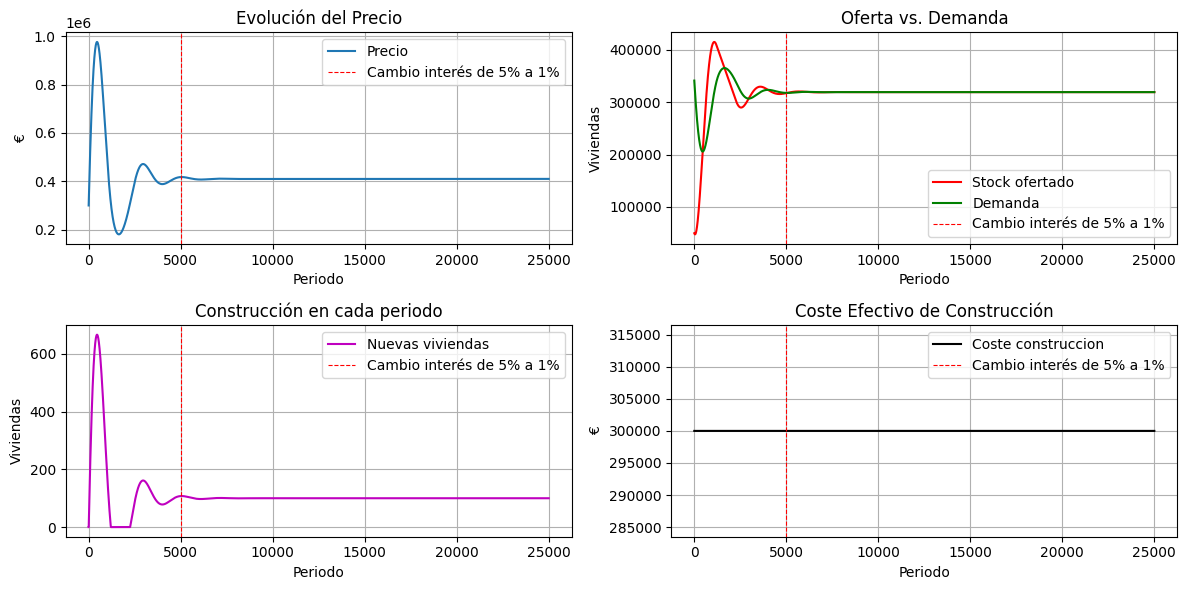

In [41]:

import numpy as np
import matplotlib.pyplot as plt


def simulate_housing_market_with_arrays(
    T,
    alpha_d, beta_d, gamma_d, delta_d, theta_d,  # Parámetros de la DEMANDA
    alpha_s, beta_s,                     # Parámetros de la OFERTA (nuevas construcciones)
    k,                                   # Velocidad de ajuste de precios
    P0, Qs0,                             # Precio y stock de vivienda iniciales
    r_array,                              # Tasa de interés en cada periodo ( long. >= T+1 )
    C_array,                              # Array con el coste base de construcción en cada periodo (long. >= T+1)
    c_fin,                                #c_fin = coste financiero
    X_array=None,                         # Array con variable exógena, si None => 0
    Y_array=None,                         # Array con valor de la renta, si None => 0
    R_const=0,                             # Demoliciones fijas por periodo
    construction_lag=1                     # Retardo en la construcción de viviendas
):
    """
    Simula un modelo dinámico de oferta y demanda de vivienda, usando directamente
    arrays de r(t), C(t) y X(t) proporcionados por el usuario, de longitud T+1.

    Ecuaciones (forma lineal básica):
      1) Qd(t) = alpha_d - beta_d*P(t) - gamma_d*r(t) + delta_d*X(t)
      2) cost_of_construction(t) = C0 + c_fin*r_array[t]
      3) I(t) = max(0, alpha_s + beta_s*( P(t) - cost_of_construction(t) ))
      4) Qs(t+1) = Qs(t) + I(t) - R_const
      5) P(t+1) = P(t) + k * [ Qd(t) - Qs(t) ]

    Nueva propuesta con retardo
        (1) Qd(t) = alpha_d - beta_d*P(t) - gamma_d*r(t) + delta_d*X(t) + theta_d*Y(t)
        (2) cost_of_construction(t) = C_array[t] + c_fin*r_array[t]
        (3) I(t) = max(0, alpha_s + beta_s*( P(t) - cost_of_construction(t) ))
        (4) Qs(t+1) = Qs(t) + I(t - lag) - R_const,  para t-lag >= 0
            (si t-lag < 0, no se suma nada porque todavía no se termina la construcción)
        (5) P(t+1) = P(t) + k * [ Qd(t) - Qs(t) ]

    Parámetros:
    -----------
    - T        : número total de periodos a simular.
    - alpha_d  : demanda base (unidades de vivienda) cuando P, r y X están en sus valores de referencia.
    - beta_d   : sensibilidad (positiva) de la demanda a los cambios en el precio P(t).
    - gamma_d  : sensibilidad de la demanda a la tasa de interés r(t).
    - delta_d  : sensibilidad de la demanda a la variable exógena X(t).
    - theta_d  : sensibilidad de la demanda a la renta Y(t).
    - alpha_s  : término base de la función de oferta nueva (si negativo, se requiere rentabilidad>0).
    - beta_s   : sensibilidad de la oferta a la rentabilidad = P(t) - C(t).
    - k        : velocidad de ajuste del precio: determina cuánto se corrige P(t+1) según el desequilibrio Qd-Qs.
    - P0       : precio inicial P(0).
    - Qs0      : stock (oferta) inicial de viviendas Qs(0).
    - r_array  : array con la tasa de interés r(t) para cada t (longitud >= T+1).
    - C_array  : array de longitud >= T+1 con el coste base de construcción en cada periodo.
    - c_fin    : sensibilidad del coste al interés => coste total = C0 + c_fin*r
    - X_array  : array con la variable exógena X(t) para cada t (longitud >= T+1).
    - Y_array  : array con la Renta Y(t) para cada t (longitud >= T+1).
    - R_const  : número absoluto de viviendas que se retiran (demoliciones) cada periodo.
    - lag     : retardo en la construcción de viviendas (por defecto, 1 periodo).

    Retorna:
    --------
    Un diccionario con:
      - 'P' : array con la evolución del precio P(t).
      - 'Qs': array con la evolución de la oferta Qs(t).
      - 'Qd': array con la evolución de la demanda Qd(t).
      - 'I' : array con la nueva construcción en cada periodo.
      -'costC' : array con el coste de construcción efectivo en cada periodo (long. T+1).
    """

        # Si no se provee X_array, usar ceros
    if X_array is None:
        X_array = np.zeros(T+1)
    if Y_array is None:
        Y_array = np.zeros(T+1)

    # Inicializamos arrays para guardar las trayectorias de las variables
    P  = np.zeros(T+1)  # Precio
    Qs = np.zeros(T+1)  # Stock ofertado
    Qd = np.zeros(T+1)  # Demanda
    I  = np.zeros(T)    # Nuevas viviendas construidas en cada periodo
    costC = np.zeros(T+1)

    # Verificamos que r_array, C_array y X_array tengan longitud suficiente
    if len(r_array) < T+1 or len(C_array) < T+1 or len(X_array) < T+1 or len(Y_array) < T+1:
        raise ValueError("Los arrays r_array, C_array, X_array y Y_array deben tener al menos T+1 elementos.")

    # Configuramos valores iniciales
    P[0]  = P0
    Qs[0] = Qs0

    # Bucle principal para el cálculo en cada periodo
    for t in range(T):
        # 1) Calculamos la demanda Qd(t) según ecuación (1)
        #    Qd(t) puede hacerse 0 si resultase negativa (por decisión de modelado).
        Qd[t] = alpha_d - beta_d*P[t] - gamma_d*r_array[t] + delta_d*X_array[t] + theta_d*Y_array[t]
        if Qd[t] < 0:
            Qd[t] = 0


        # 2) Coste de construcción efectivo (base + financiero)
        costC[t] = C_array[t] + c_fin * r_array[t]

        # 3) Se construye I(t) viviendas si la rentabilidad es positiva
        rentabilidad = P[t] - costC[t]
        I[t] = max(0, alpha_s + beta_s * rentabilidad)

        # 4) Actualizar stock (modelo sin retardo)
        #Qs[t+1] = Qs[t] + I[t] - R_const
        #if Qs[t+1] < 0:
            #Qs[t+1] = 0

        # (4) Actualizar stock con retardo
        #     Las viviendas construidas en t’ se terminan en t’+construction_lag.
        #     Por tanto, en t+1 se suman las viviendas I[t+1 - lag].
        #     Equivalente a: Qs(t+1) = Qs(t) + I(t - (lag-1)) - R_const, si t-(lag-1) ≥ 0.
        #     Aquí lo implementamos corrigiendo índice para no salirnos del array.
        if t - construction_lag >= 0:
            viviendas_terminadas = I[t - construction_lag]
        else:
            viviendas_terminadas = 0

        Qs[t+1] = Qs[t] + viviendas_terminadas - R_const
        if Qs[t+1] < 0:
            Qs[t+1] = 0

        # 5) Ajuste de precio
        P[t+1] = P[t] + k * (Qd[t] - Qs[t])
        if P[t+1] < 0:
            P[t+1] = 0

    # Coste de construcción y demanda en el último periodo T
    costC[T] = C_array[T] + c_fin * r_array[T]
    Qd[T] = max(0,alpha_d - beta_d * P[T] - gamma_d * r_array[T] + delta_d * X_array[T] + theta_d * Y_array[T])

    return {
        'P': P,
        'Qs': Qs,
        'Qd': Qd,
        'I': I,
        'costC': costC
    }



# ----------------------------------------------------------------------------
# EJEMPLO DE USO
# ----------------------------------------------------------------------------
if __name__ == "__main__":
    # 1) Definimos el número de periodos
    T = 25_000  # Por ejemplo.
    construction_lag = 0
     
    # 2) Definimos los parámetros del modelo
    # Parámetros de la DEMANDA (en unidades ABS)
    alpha_d = 200_000   # Demanda base de 200.000 viviendas
    beta_d  = 0.2    # Efecto del precio sobre la demanda
    gamma_d = 20_000       # Efecto de cada punto % de interés sobre la demanda
    delta_d = 200       # Efecto de la variable exógena X en la demanda
    theta_d = 5      # Efecto de la renta en la demanda


    # Parámetros de la OFERTA
    alpha_s = -10       # Parte base de construcción (si la rentabilidad < X, produce 0)
    beta_s  = 0.001     # Sensibilidad de la construcción a (P - C)

    # Velocidad de ajuste del precio
    k = 0.01

    # Costes base y financiación
    c_fin = 20000  # coste extra por punto %

    # Condiciones iniciales
    P0   = 300_000  # Precio inicial de la vivienda (en euros)
    Qs0  = 50_000  # Stock inicial de viviendas
    r0   = 5.0      # Tasa de interés inicial (%)
    C0   = 200_000  # Coste de construcción (euros)
    X0   = 5        # Valor inicial de la variable exógena (p.e. índice poblacional)
    R0   = 100     # Viviendas que se retiran cada periodo (demoliciones)
    Y0   = 30000    # Renta

    # 3) Creamos arrays para r, C y X de longitud T+1
    #    Comenzamos con valores constantes, pero podrías modificar
    #    individualmente cada elemento si deseas shocks múltiples.

    r_array = np.full(T+1, r0)        # Tasa de interés 3%
    C_array = np.full(T+1, C0)  # Coste construcción 200.000€
    X_array = np.full(T+1, X0)        # Variable exógena con valor 5
    Y_array = np.full(T+1, Y0)        # Renta con valor 30000

    # EJEMPLO: A mitad de la simulación, subimos r a 5%
    # (puedes hacer cualquier tipo de cambio en cualquier momento).
    shock_time = 5_000
    #r_array[shock_time:] = 1.0
    # r creciente de 1% a 5% en t=10_000 y terminando en t=15_000
    #r_array[shock_time:shock_time+5_000] = np.linspace(5.0, 1.0, 5_000)
    #r_array[shock_time+5_000:] = 1.0
    #r_array[shock_time:] = np.linspace(5.0, 1.0, T+1-shock_time)

    # r sinousoidal de 1% a 5% en t=10_000 y terminando en t=15_000
    #r_array[shock_time:shock_time+10_000] = 5.0 + 3.5*np.sin(np.linspace(0, 1.5*np.pi, 10_000))
    #r_array[shock_time+10_000:] = 1.5


    shock_time_2 = 15_000
    #r_array[shock_time_2:] = 1.0

    # EJEMPLO: Reducir coste de construcción en t=10_000 a la mitad
    shock_time_2 = 10_000
    #C_array[shock_time_2:] = 100_000.0

    # EJEMPLO: Incrementar la variable exógena X en t=15_000
    shock_time_3 = 15_000
    #X_array[shock_time_3:] = 8.0

    # 4) Llamamos a la función con estos arrays
    results = simulate_housing_market_with_arrays(
        T,
        alpha_d, beta_d, gamma_d, delta_d, theta_d,
        alpha_s, beta_s,
        k,
        P0, Qs0,
        r_array, C_array, c_fin,
        X_array,
        Y_array,
        R_const=R0,
        construction_lag = construction_lag

    )

    P  = results['P']
    Qs = results['Qs']
    Qd = results['Qd']
    I  = results['I']
    costC = results['costC']

    # Graficamos una parte de las series
    upper_lim = T  # para no alargar excesivamente el gráfico
    plt.figure(figsize=(12,6))

    # Precio
    plt.subplot(2,2,1)
    plt.plot(range(upper_lim+1), P[:upper_lim+1], label="Precio")
    plt.axvline(x=shock_time, color='red', linestyle='--', linewidth=0.8, label= "Cambio interés de 5% a 1%")
    plt.title("Evolución del Precio")
    plt.xlabel("Periodo")
    plt.ylabel("€")
    plt.legend()
    plt.grid(True)

    # Oferta vs. Demanda
    plt.subplot(2,2,2)
    plt.plot(range(upper_lim+1), Qs[:upper_lim+1], 'r', label="Stock ofertado")
    plt.plot(range(upper_lim+1), Qd[:upper_lim+1], 'g', label="Demanda")
    plt.axvline(x=shock_time, color='red', linestyle='--', linewidth=0.8, label= "Cambio interés de 5% a 1%")
    plt.title("Oferta vs. Demanda")
    plt.xlabel("Periodo")
    plt.ylabel("Viviendas")
    plt.grid(True)
    plt.legend()

    # Construcción
    plt.subplot(2,2,3)
    plt.plot(range(upper_lim), I[:upper_lim], 'm', label="Nuevas viviendas")
    plt.axvline(x=shock_time, color='red', linestyle='--', linewidth=0.8, label= "Cambio interés de 5% a 1%")
    plt.title("Construcción en cada periodo")
    plt.xlabel("Periodo")
    plt.ylabel("Viviendas")
    plt.grid(True)
    plt.legend()

    # Coste de construcción efectivo
    plt.subplot(2,2,4)
    plt.plot(range(upper_lim+1), costC[:upper_lim+1], 'k', label="Coste construccion")
    plt.axvline(x=shock_time, color='red', linestyle='--', linewidth=0.8, label= "Cambio interés de 5% a 1%")
    plt.title("Coste Efectivo de Construcción")
    plt.xlabel("Periodo")
    plt.ylabel("€")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


In [11]:

def static_equilibrium_with_financing(
    alpha_d, beta_d, gamma_d, delta_d,   # Parámetros DEMANDA
    alpha_s, beta_s,                    # Parámetros OFERTA (nueva construcción)
    C0, c_fin,                          # Coste base de construcción y coste financiero (C(r) = C0 + c_fin*r)
    r, X,                               # Tasa de interés y variable exógena
    R_const
):
    """
    Calcula el precio de equilibrio estacionario P* asumiendo que:
      I(P, r) = alpha_s + beta_s * [P - C(r)] = R_const
    donde C(r) = C0 + c_fin*r.
    Así, I(P*, r) = R_const determina P*.

    PARÁMETROS
    ----------
    alpha_s : término base de la función de construcción (puede ser negativo).
    beta_s  : sensibilidad de la construcción a la rentabilidad (P - C(r)).
    C0      : coste base de construcción.
    c_fin   : factor que multiplica r para representar el coste financiero.
    r       : tasa de interés (por ejemplo, 3.0 => 3%).
    R_const : número de viviendas que se retira (demoliciones) en cada periodo.

    RETORNA
    -------
    P_star : precio estacionario en el que la construcción compensa la retirada.
    I_star : (= R_const) viviendas construidas en el equilibrio.
    """

    # 1) Coste de construcción efectivo en función de r
    cost_construction = C0 + c_fin * r

    # 2) De la ecuación: alpha_s + beta_s * (P_star - cost_construction) = R_const
    #    se despeja P_star:
    #       beta_s * (P_star - cost_construction) = R_const - alpha_s
    #       P_star = cost_construction + (R_const - alpha_s)/beta_s

    P_star = cost_construction + (R_const - alpha_s) / beta_s

    # La construcción en equilibrio I_star es igual a R_const
    I_star = R_const

    # Calculo de P_2 calculandolo por el lado de la demanda 
    # Esta mal porque asume que la demanda es igual a la oferta creada en ese instante,
    # no mira el stock total, ¿Como puedo hacer para mirar el total? 
    # Resulta curioso que el precio en regimen permamente este totalmente determinado por la tasa de retiro y
    # el coste de construccion.

    numerator   = alpha_s - alpha_d - gamma_d*r + delta_d*X + beta_s*cost_construction
    denominator = -(beta_d + beta_s)
    
    if abs(denominator) < 1e-10:
        # Evitar división por 0 => significaría que no hay forma lineal de resolver esto
        return (False, ("Denominador ~ 0",))
    
    P_2 = numerator / denominator
    print(P_2)

    return P_star, I_star

P_star, I_star = static_equilibrium_with_financing(
    alpha_d, beta_d, gamma_d, delta_d,
    alpha_s, beta_s,
    C0, c_fin,
    r0, X0,
    R0
)
print(f"Precio de equilibrio: {P_star:.2f} €")
print(f"Construcción en equilibrio: {I_star:.2f} viviendas")

2481144.278606965
Precio de equilibrio: 410000.00 €
Construcción en equilibrio: 100.00 viviendas


In [73]:
a = np.array([1,2,3,4,5])
a[2:]

array([3, 4, 5])

In [ ]:
def static_equilibrium(
    alpha_d, beta_d, gamma_d, delta_d,   # Parámetros de la DEMANDA
    alpha_s, beta_s,                     # Parámetros de la OFERTA (flujo de nuevas viviendas)
    r, C, X,                             # Tasa de interés, coste de construcción y variable exógena
    R_const
):
    """
    Calcula el equilibrio "estático" (o estacionario) de un modelo de vivienda
    donde cada periodo se retiran R_const viviendas (demoliciones), compensadas
    por la nueva construcción I(P). Asumimos que en equilibrio estacionario:

        I(P*) = alpha_s + beta_s * (P* - C) = R_const

    De ahí se obtiene P*, y luego se calcula la demanda estática Qᵈ(P*).

    Parámetros:
    -----------
    alpha_d : parte base de la demanda.
    beta_d  : sensibilidad de la demanda al precio (debe ser > 0).
    gamma_d : sensibilidad de la demanda a la tasa de interés r.
    delta_d : sensibilidad de la demanda a la variable exógena X.
    
    alpha_s : término base de la función de oferta nueva (puede ser negativo).
    beta_s  : sensibilidad de la oferta a la rentabilidad (P - C).
    
    r       : tasa de interés (p.e., 3.0 para un 3%).
    C       : coste de construcción por vivienda (en euros o la unidad que uses).
    X       : variable exógena (por ejemplo, un índice de población, renta, etc.).
    R_const : número “fijo” de viviendas que se demuelen o retiran en cada periodo.

    Retorna:
    --------
    (P_star, Q_star)
      - P_star : precio de equilibrio estacionario.
      - Q_star : la demanda a ese precio (también interpretada como “cantidad demandada
                 en equilibrio”).
    
    Nota:
    -----
    - Este planteamiento asume que en equilibrio la cantidad de viviendas construidas
      cada periodo es exactamente R_const, de forma que el ‘stock’ total no varíe
      a lo largo del tiempo.
    - Q_star es la demanda en ese precio, que en muchos modelos se identifica con
      las transacciones o la cantidad efectivamente “comprada” en el mercado.
    - Si Q_star saliera negativa, se trunca a 0, dado que no tendría sentido
      una demanda negativa.
    """

    # 1) Resolvemos la condición de equilibrio de la oferta nueva:
    #    I(P*) = alpha_s + beta_s * (P* - C) = R_const
    #
    #    => beta_s * (P* - C) = R_const - alpha_s
    #    => P* = C + (R_const - alpha_s) / beta_s
    #
    # Asumiendo beta_s > 0 y que el lado derecho no sea negativo (si te interesa
    # evitar P* < 0, lo controlas después).

    P_star = C + (R_const - alpha_s) / beta_s

    # 2) Calculamos la demanda estática a ese precio:
    #    Qᵈ(P*) = alpha_d - beta_d*P* - gamma_d*r + delta_d*X

    Q_star = alpha_d - beta_d*P_star - gamma_d*r + delta_d*X

    # Si la demanda resultase negativa, la forzamos a 0 (opcional):
    if Q_star < 0:
        Q_star = 0


      

    return P_star, Q_star

In [ ]:

# Calculamos el equilibrio estático
P_star, Q_star= static_equilibrium(
    alpha_d, beta_d, gamma_d*2, delta_d,
    alpha_s/10, beta_s,
    2, C0, X0, R0
)

# Mostramos resultados
print(f"Precio de equilibrio (P*): {P_star:,.2f} €")
print(f"Cantidad de equilibrio (Q*):  {Q_star:,.2f} viviendas")
# (Qd_star y Qs_star deberían ser prácticamente iguales si el modelo es lineal y no saturado). 

Precio de equilibrio (P*): 301,000.00 €
Cantidad de equilibrio (Q*):  0.00 viviendas
